In [ ]:
import os
import glob
import numpy as np
import random
from collections import Counter
import librosa
from librosa import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/Shared drives/deep learning"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/Shared drives/deep learning


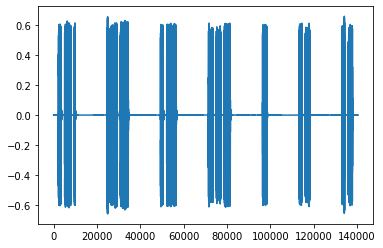

In [ ]:
## Read the audio

data_path = "data/test_samples/"
audio_path = os.path.join(data_path, "sample_morse_audio.ogg")
image_path = os.path.join(data_path, "sample_morse_audio.png")

y, sr = librosa.load(audio_path, sr=5500, mono=True, offset=0.0, duration=None)
plt.plot(y)
plt.show()

In [ ]:
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])


    # 6. Map the characters in label to numbers
    # label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img}



In [ ]:
## Convert and save the plot in the appropriate format

plt.gray()
fig, ax = plt.subplots(1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')
librosa.display.waveplot(y, sr, alpha=0.8)
ax.axis('off')
fig.savefig(image_path, dpi=125, frameon='false')
plt.close(fig)
batch_size = 10
img_width = 650
img_height = 550

# img = tf.io.read_file(image_path)
# img = tf.io.decode_png(img, channels=1)
# img = tf.image.convert_image_dtype(img, tf.float32)
# img = tf.image.resize(img, [img_height, img_width])
# img = tf.transpose(img, perm=[1, 0, 2])

test_dataset = tf.data.Dataset.from_tensors(np.array(image_path))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

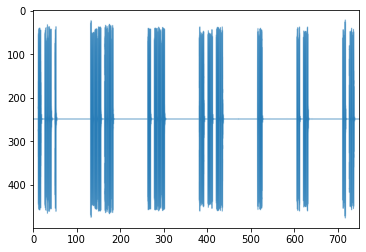

In [ ]:
## Plot the saved image
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

In [ ]:
characters = list('abcdefghijklmnopqrstuvwxyz0123456789,.?;:-_()=+@$!&/\'\" ')

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
import crnn_scripts.crnn_model_1 as crnn
model = crnn.build_model(img_width, img_height, len(characters))
model.summary(

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 650, 550, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 650, 550, 64) 640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 325, 275, 64) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 325, 275, 32) 18464       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:
randomDataset = False
x = "ctc_images_random" if randomDataset else "ctc_large_images"
checkpoint_path = "checkpoints/{}/50_epochs_steel".format(x)
model.load_weights(checkpoint_path)
# print(load_status.assert_consumed())


In [ ]:
print("Image shape: {}".format(img.shape))

print("New batch shape: {}".format(img.shape))

Image shape: (500, 750, 4)
New batch shape: (500, 750, 4)


In [ ]:
print(test_dataset)

<MapDataset shapes: {image: (1, 650, 550, 1)}, types: {image: tf.float32}>


In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :50
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# For random sampling from each batch
import random
samples_per_batch = 1
sample_text = ""
err_w, total_words, err_c, total_chars = 0, 0, 0, 0

# Iterate over the test dataset batches
sample_ind = 1
for batch in test_dataset.as_numpy_iterator():
  batch_images = batch["image"]
  
  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)




  if random.random() < 0.4:
    batch_size = len(pred_texts)
    sample_indices = random.sample(range(batch_size), samples_per_batch)
    for i in sample_indices:
      sample_text += "Reconstruction:\t{}\n\n".format(pred_texts[i])
      sample_ind += 1



In [ ]:
print(sample_text)

Reconstruction:	 she eee 34e e s3e hhh  s ss sh [UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


